In [129]:
import numpy as np
import matplotlib.pyplot as plt
import heapq #topk


Fisher Analysis End!
The expected value is  [2, 2, 1, 1]
The predicted value is : [2 2 1 1]


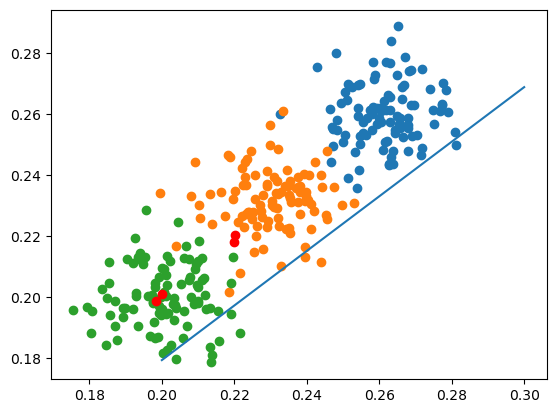

In [132]:
#LDA线性回归分析
class Fisher_Analysis:
    def __init__(self,classification=3,tar_dim=1):
        
        self.S=None #类内协方差矩阵，等于每一个类别的协方差矩阵的求和
        self.B=None #类间协方差矩阵
        self.classification=classification #总类别
        self.tar_dim=tar_dim #降维后的度数
        
        self.train_data=None #训练数据 type:list 后面用于画图
        
        assert(self.tar_dim<=classification-1) #最多只能降维到类别数-1
        
        self.w=[] #存放特征向量
        self.means=[] #每一个类别的均值
    def fit(self,train_data,train_label):
        '''
            train_data(type:list)[array,array,array,......]
            train_label(type:list)[array,array,array,......]
        '''
        
        self.train_data=train_data
        
        #求出S，每一个类别的协方差矩阵相加
        for data in train_data:
            if self.S is None:
                self.S=np.cov(data,rowvar=False) #开始的时候是None，直接赋值
            else:
                self.S+=np.cov(data,rowvar=False) #后面叠加
           
        #求出每一个类别的均值，
        for data in train_data:
            self.means.append(np.mean(data,axis=0)) #在样本的维度上进行叠加
            
        #求出所有样本的均值
        total_train_data=np.concatenate(train_data,axis=0)
        total_mean=np.mean(total_train_data.reshape(-1,total_train_data.shape[-1]),axis=0) #所有的样本全部打包成一个数据集，(B,)
        total_mean=total_mean.reshape(-1,1) #矩阵的形状变为 [B,]--->[B,1],便于后面矩阵乘法

        
        #计算B，计算每一个类别u_i和整体数据u的协方差矩阵，然后再按照每一个类别的数量加权求和
        for index in range(len(self.means)):
            
            self.means[index]=self.means[index].reshape(-1,1)#矩阵的形状变为 [B,]--->[B,1],便于后面矩阵乘法
            cov_matrix=np.matmul(self.means[index]-total_mean,(self.means[index]-total_mean).T) #计算每一个类别u_i和整体数据u的协方差矩阵
            
            #加权求和
            if self.B is None:
                self.B=train_data[index].shape[0]*cov_matrix
            else:
                self.B+=train_data[index].shape[0]*cov_matrix
        
        #求出我们要进行特征向量分解的矩阵
        self.tar_matrix=np.matmul(np.linalg.inv(self.S),self.B)
        
        
        #求特征值和特征向量
        eigenvalue,eigenvector=np.linalg.eig(self.tar_matrix)
        eigenvalue=list(eigenvalue)
        eigenvector=eigenvector.T
        
        #取出前tar_dim个特征值对应的特征向量
        topk_eigen=heapq.nlargest(self.tar_dim, range(len(eigenvalue)), eigenvalue.__getitem__)
        
        for index in topk_eigen:
            self.w.append(eigenvector[index].reshape(-1,1))
        print("Fisher Analysis End!")
        
    #目前只支持一维,降维演示
    def proj_draw(self):
        #首先画出新的基准
        k=self.w[0][1]/self.w[0][0] #画出斜率
        xline=np.linspace(0.2,0.3,50) #注意linspace是[]，两边的值都能取到
        yline=[k*item for item in xline]
        plt.plot(xline,yline)
        
        #画出每一个类别的分布
        for index in range(len(self.train_data)):
            plt.scatter(self.train_data[index][:,0].reshape(-1),self.train_data[index][:,1].reshape(-1))
            
            
    #对于新输入的数据进行预测
    def predict(self,data):
        '''
        data--- shape：[Batch,Hidden_Dim] （Hidden_Dim就是你原来数据的特征维度）
                type： ndarray
        '''
        
        #求出每一个类别的均值向量投影后的向量
        proj_means=[]
        for mean in self.means:
            temp_dimension=[]
            for _w in self.w:
                #内积就是投影的过程
                temp_dimension.append(np.dot(_w.T,mean).item())
            proj_means.append(temp_dimension)
            
        #proj_means numpy的形状是 [类别数，] 记录原来每一个均值向量投影后的新向量
        proj_means=np.array(proj_means)
            
            
        #预测数据进行投影降维
        proj_tar=[]
        for _w in self.w:
            proj_tar.append(np.matmul(data,_w))
        
        #这里transpose是将batchsize放到第一维，便于后面求mse
        #形状的变化为：[新维度,batchsize,1]---> [batchsize,新维度，1]
        proj_tar=np.transpose(np.array(proj_tar),(1,0,2))
        
        #形状的变化为：[batchsize,新维度，1]---> [batchsize,新维度]
        proj_tar=proj_tar.reshape(proj_tar.shape[0],proj_tar.shape[1])
        
        #计算MSE，判别类别
        Mse_dis=[]
        for proj_data in proj_tar:# 遍历每一个样本
            dis=[] 
            for proj_mean in proj_means: # 遍历每一个类别均值
                dis.append(np.mean((proj_mean-proj_data) ** 2)) #求MSE
            Mse_dis.append(dis)
        
        Mse_dis=np.array(Mse_dis) # Mse_dis形状为[batchsize,类别数]，里面存放mse距离
        
        classification=np.argmin(Mse_dis,axis=1) #求出最小的距离下标，就是最终预测类别
        
        return classification
    
    
    #画出预测点的位置
    def predict_draw(self,data):
        plt.scatter(data[:,0].reshape(-1),data[:,1].reshape(-1),c='r')
            
if __name__=='__main__':
    
    #准备数据
    train_data_0=np.random.normal(0.26,0.01,(100,2))
    train_data_1=np.random.normal(0.23,0.01,(100,2))
    train_data_2=np.random.normal(0.20,0.01,(100,2))
    train_label_0=np.full((60,1),0)
    train_label_1=np.full((60,1),1)
    train_label_2=np.full((60,1),2)
    train_data=[train_data_0,train_data_1,train_data_2]
    train_label=[train_label_0,train_label_1,train_label_2]
    
    
    #进行降维/训练
    fisher=Fisher_Analysis(3,1)
    fisher.fit(train_data,train_label)
    fisher.proj_draw()
    
    
    #进行预测
    test_data=np.concatenate([np.random.normal(0.20,0.001,(2,2)),np.random.normal(0.22,0.001,(2,2))])

    result=fisher.predict(test_data)
    fisher.predict_draw(test_data)
    
    print("The expected value is ",[2,2,1,1])
    print("The predicted value is :",result)
    